# Import needed modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get Data

In [3]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


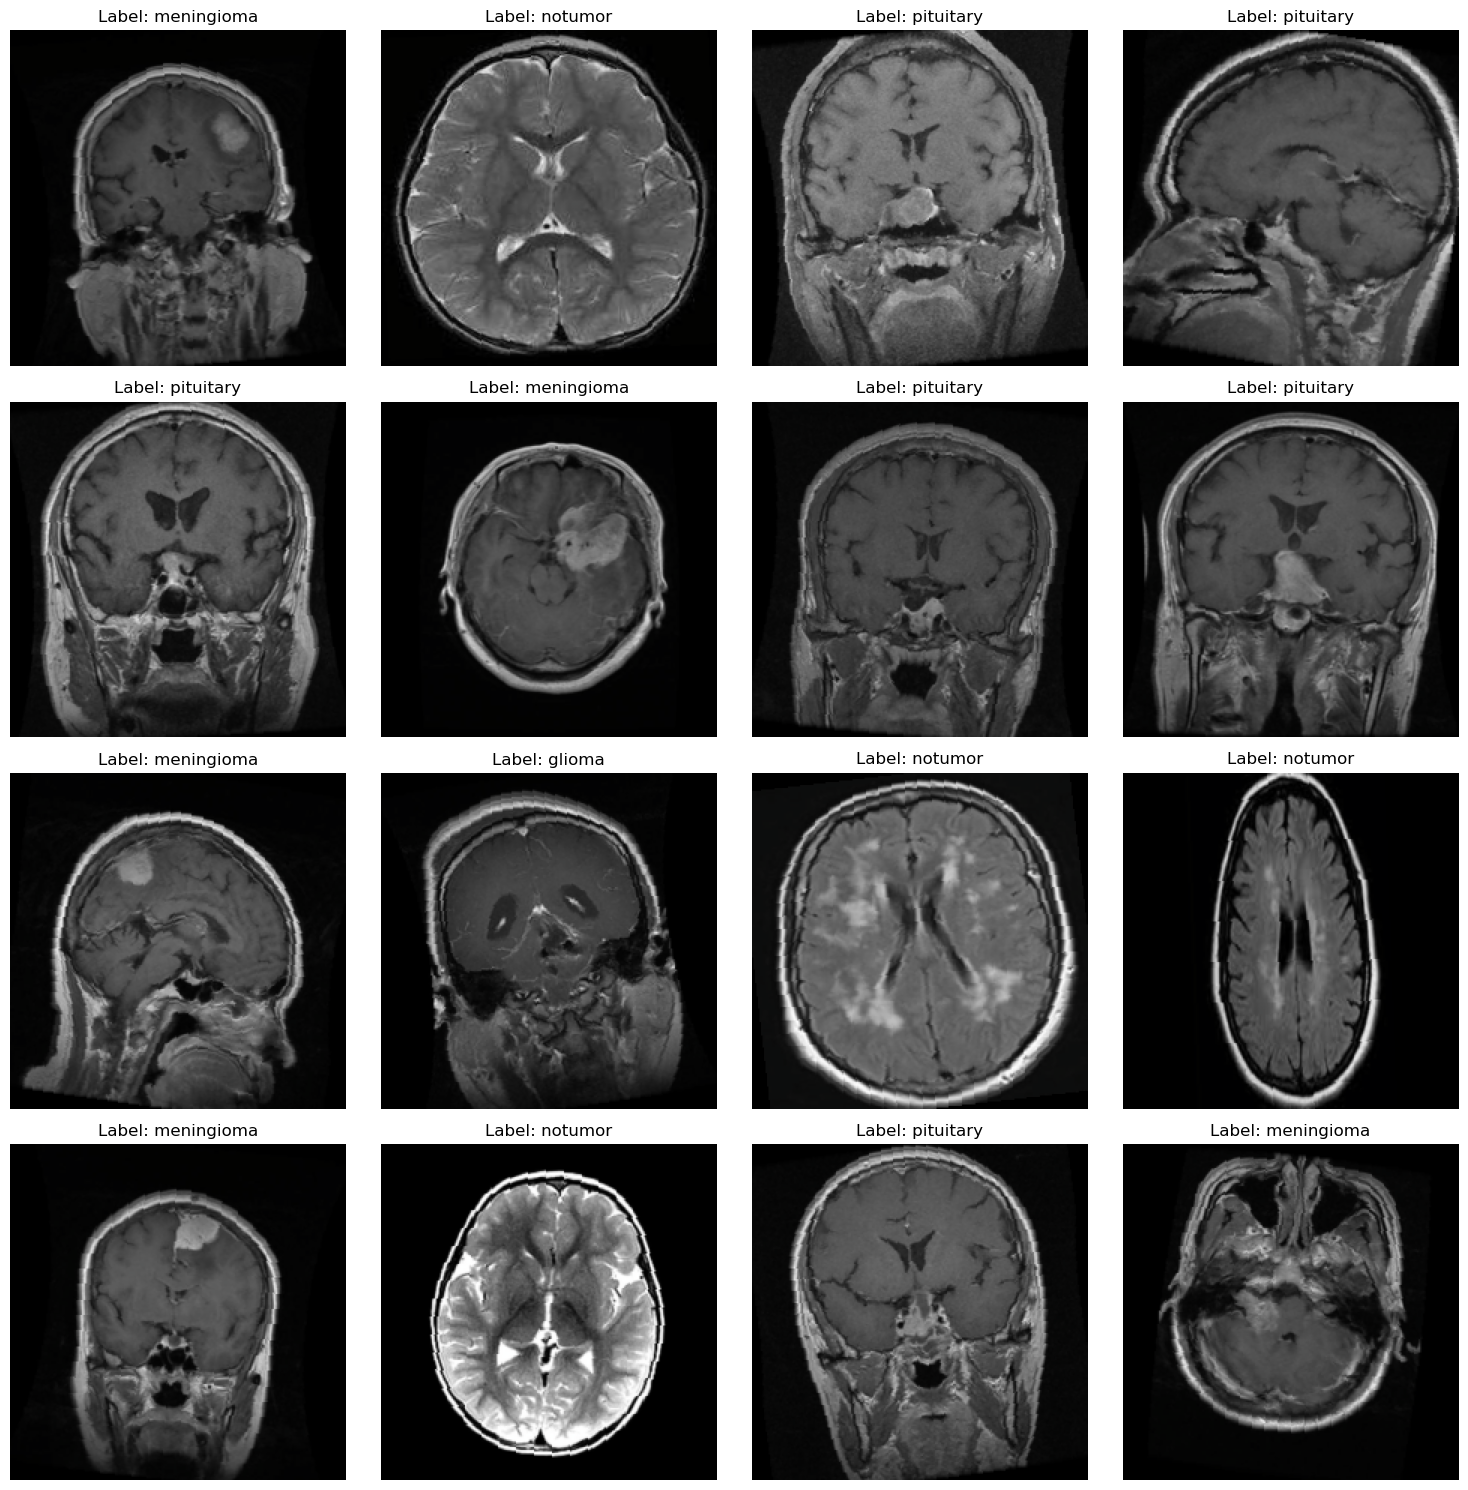

In [4]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model Architecture

In [14]:
import torch
import torch.nn as nn
from torchvision import models

# Multi-Head Attention Block
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU()
        )

    def forward(self, q, k, v):
        # Apply multi-head attention
        attn_output, _ = self.mha(q, k, v)
        # Feed through FC layer for additional processing
        return self.fc(attn_output)

# Combined Model with ResNet, VGG16, and EfficientNet
class TumorClassifierWithMHA(nn.Module):
    def __init__(self, num_classes, embed_dim=512, num_heads=8):
        super(TumorClassifierWithMHA, self).__init__()
        # Load pre-trained models
        self.resnet = models.resnet50(pretrained=True)
        self.vgg16 = models.vgg16(pretrained=True)
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        # Replace final layers with feature extractors
        self.resnet.fc = nn.Identity()
        self.vgg16.classifier = nn.Sequential(*list(self.vgg16.classifier[:-1]))  # Remove last FC
        self.efficientnet.classifier = nn.Identity()

        # Define feature dimension for each model
        self.resnet_out = 2048
        self.vgg16_out = 4096
        self.efficientnet_out = 1280

        # Projection layers to ensure all features have the same embed_dim
        self.resnet_proj = nn.Linear(self.resnet_out, embed_dim)
        self.vgg16_proj = nn.Linear(self.vgg16_out, embed_dim)
        self.efficientnet_proj = nn.Linear(self.efficientnet_out, embed_dim)

        # Multi-head attention
        self.mha = MultiHeadAttention(embed_dim, num_heads)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Extract features from each backbone
        resnet_features = self.resnet_proj(self.resnet(x))
        vgg16_features = self.vgg16_proj(self.vgg16(x))
        efficientnet_features = self.efficientnet_proj(self.efficientnet(x))

        # Combine features into a sequence for MHA
        features = torch.stack([resnet_features, vgg16_features, efficientnet_features], dim=1)

        # Apply Multi-Head Attention
        attn_output = self.mha(features, features, features)

        # Aggregate the attention output and classify
        aggregated_features = torch.mean(attn_output, dim=1)  # Global average pooling
        output = self.classifier(aggregated_features)
        return output

# Specify the number of classes
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TumorClassifierWithMHA(num_classes=num_classes).to(device)

# Print model architecture (optional)
print(model)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 371MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Download

TumorClassifierWithMHA(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [17]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training

In [18]:
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [19]:
# Training loop
num_epochs = 60
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')

    
    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')


Epoch [1/60], Training Loss: 259.6173, Training Accuracy: 75.98%, Validation Loss: 0.5793, Validation Accuracy: 84.06%
Epoch [2/60], Training Loss: 218.4836, Training Accuracy: 79.13%, Validation Loss: 0.9458, Validation Accuracy: 57.89%
Epoch [3/60], Training Loss: 356.6320, Training Accuracy: 60.80%, Validation Loss: 1.3937, Validation Accuracy: 48.74%
Epoch [4/60], Training Loss: 407.2855, Training Accuracy: 45.62%, Validation Loss: 0.9073, Validation Accuracy: 61.86%
Epoch [5/60], Training Loss: 373.3885, Training Accuracy: 52.77%, Validation Loss: 1.0908, Validation Accuracy: 46.22%
Epoch [6/60], Training Loss: 454.4857, Training Accuracy: 39.01%, Validation Loss: 1.3951, Validation Accuracy: 22.88%
Epoch [7/60], Training Loss: 495.8237, Training Accuracy: 23.70%, Validation Loss: 1.3844, Validation Accuracy: 30.89%
Epoch [8/60], Training Loss: 494.3499, Training Accuracy: 27.92%, Validation Loss: 1.3816, Validation Accuracy: 30.89%
Epoch [9/60], Training Loss: 494.0457, Training 

# Model Evaluation

In [20]:
accuracy = correct / total
print(f'Validation Accuracy: {accuracy:.2%}')

Validation Accuracy: 30.89%


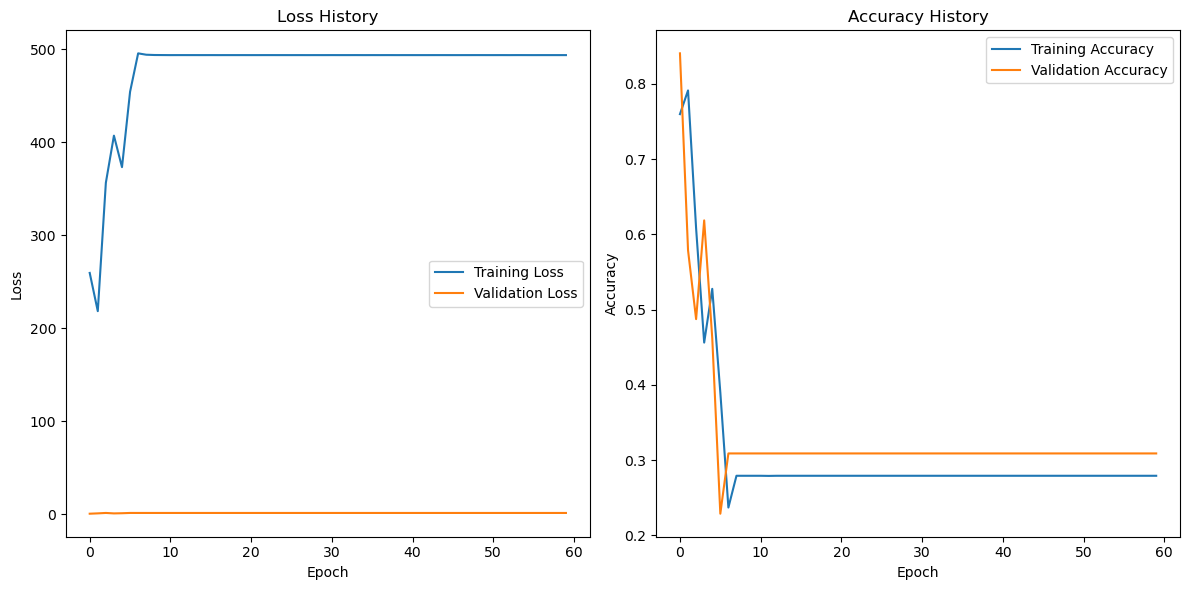

In [21]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()